# Simple logistic model with uncertainty
We want
- Logistic regression 
- LASSO/Ridge regularization
- Uncertainty quantification and prior-ification

## Model
Let $Y_{it}$ be the Republican _score_, defined as the proportion of votes Republican received over the total votes received by Republican and Democratic candidates. Let $W_{it}$ be whether the Republican wins.

Assume that 
$$
Y_{it} \sim \mathcal{N}(X\beta, \sigma^2)
$$
We infer $\beta$ via a penalized logistic regression with cross-validation selection of the penalities. We infer $\sigma^2$ by simply taking the variance of the prediction errors.

On the test set, assume that polls are drawn from $\text{Bin}(n, Y) \approx \mathcal{N}(nY, nY(1-Y))$. This is a normal likelihood with normal prior Bayesian model, and the posterior is easy to compute.

In [1]:
import us
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

In [67]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
# import geopandas as gpd
sns.set_style('white')
plt.rcParams['figure.dpi'] = 150

In [3]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, ElasticNetCV

In [5]:
df = feather.read_dataframe('data/final_merged.feather').drop_duplicates()
df['raceyear'] = df['year']

In [6]:
trends = pd.read_csv('data/google_trends_3.csv').iloc[:,2:].drop_duplicates().rename(columns={'year' : 'raceyear'})

In [7]:
trends = (trends.groupby(['raceyear', 'district', 'state_fips']).mean()
          .reset_index()
          .assign(
              rep_to_tot_nov=lambda x : x['rep_cand_nov'] / (x['dem_cand_nov'] + x['rep_cand_nov']),
              rep_to_tot_oct=lambda x : x['rep_cand_oct'] / (x['dem_cand_oct'] + x['rep_cand_oct']),
          ))

In [8]:
df = (df.merge(trends[['raceyear', 'district', 'state_fips', 'rep_cand_nov', 
                       'dem_cand_nov','rep_to_tot_nov', 'rep_to_tot_oct']], how='left',))

In [9]:
cols = ['rep_incumbent', 'dem_incumbent', 'dem_is_female', 'rep_is_female',
       'dem_percent', 'minority_percentage', 'pres_approval', 'same_as_pres_party_rep',
       'same_as_pres_party_dem', 'log_med_income', 'percent_bachelor_or_above', 'rep_cand_nov', 
        'rep_to_tot_oct', 'rep_to_tot_nov']
#        'rep_cand_oct', #'rep_cand_nov', 
#         'dem_cand_oct', #'dem_cand_nov', 'rep_to_tot_nov', 
#         'rep_to_tot_oct']

for year in df['raceyear'].unique():
    df.loc[df['raceyear'] == year, cols] = (df.loc[df['raceyear'] == year, cols]
                                        .fillna(df.loc[df['raceyear'] == year, cols]
                                                .mean()))

In [10]:
df = df.merge(past, how='left')

In [11]:
state = pd.get_dummies(df['state']).iloc[:,:-1]

In [12]:
df = pd.concat([df, state], axis=1, sort=False)

In [13]:
# fill na stuff
not_failing = (df[cols].isnull().sum(axis=1) <= 3) & (df['raceyear'] < 2018)
df.loc[not_failing, cols] = df.loc[not_failing, cols].fillna(df.loc[not_failing, cols].mean())

In [14]:
non_dummies = ['rep_score'] + cols
covariate_cols = non_dummies + list(state.columns)
x_cols = covariate_cols[1:]

In [15]:
interaction = []
for i, x1 in enumerate(x_cols):
    for x2 in x_cols[i:]:
        col1 = df[x1].astype(float) 
        col2 = df[x2].astype(float)
        interact = col1 * col2
        
        # Prevent simple collinearity
        if (interact != col1).any() and  (interact != col2).any() and (interact != 0).any():
            df[f'{x1}_x_{x2}'] = interact
            interaction.append(f'{x1}_x_{x2}')

In [16]:
data = df[['raceyear'] + covariate_cols + interaction].copy().astype(float)

In [17]:
train = data.query('raceyear < 2018').drop('raceyear', axis=1).dropna().drop_duplicates()
test = data.query('raceyear == 2018').drop('raceyear', axis=1)

In [18]:
# we don't predict uncontested races
uncontest = df.query('raceyear==2018')
uncontest_index = uncontest[uncontest['dem_uncontested'] | uncontest['rep_uncontested']].index
test_contest = test[~test.index.isin(uncontest_index)].copy()
test_uncontest = test[test.index.isin(uncontest_index)].copy()

In [20]:
# info := basic identifiers of district
test_info = df.loc[test_contest.index, ['state', 'state_fips','district','fivethirtyeight_district']].copy()
train_info = df.loc[train.index, ['state', 'state_fips','district', 'raceyear','total_votes']].copy()

In [ ]:
# weigh election results by number of votes, CLT
# w = (train_info['total_votes'].fillna(train_info['total_votes'].mean())) ** .5
# w /= w.sum()

In [28]:
y = train['rep_score']
X = train.loc[:, 'rep_incumbent':].astype(float)

foldid = np.random.choice(list(range(10)), size=len(X))

model = ElasticNetCV(l1_ratio=np.linspace(0.1, 1, 10), n_alphas=50,
                   fit_intercept=True, normalize=True, cv=10,
                   copy_X=True)

model.fit(X, y)
# fit = cvglmnet(x=X.values.copy(), y=y.values.copy(), nlambda=20,
#                weights=w.values.copy(),
#                alpha=.9, family='gaussian', foldid=foldid)

/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coo

/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coo

/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/sklearn/linear_model/coo

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
       max_iter=1000, n_alphas=50, n_jobs=None, normalize=True,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [32]:
np.mean((y - model.predict(X))**2)**.5

0.06057798386718258

In [40]:
new = model.mse_path_.mean(axis=2)
new.shape

(10, 50)

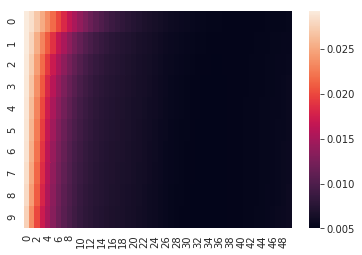

In [42]:
sns.heatmap(new)

In [55]:
coefs = pd.Series(model.coef_, index=X.columns)
nonzero_coefs = coefs[coefs != 0]
nonzero_coefs[nonzero_coefs.abs().argsort()].to_frame().style.background_gradient()

,0
rep_cand_nov_x_rep_cand_nov,-4.45011e-06
dem_is_female_x_Florida,-1.57883e-05
rep_cand_nov_x_Mississippi,2.06003e-05
log_med_income_x_Iowa,-4.70563e-05
rep_cand_nov_x_Tennessee,5.91219e-05
rep_cand_nov_x_North Dakota,6.41109e-05
rep_cand_nov_x_Pennsylvania,-7.48648e-05
rep_cand_nov_x_Massachusetts,-7.64558e-05
dem_is_female_x_rep_cand_nov,-0.000105702
rep_cand_nov_x_Maryland,-0.000132592


In [56]:
model.predict(X).shape

(1530,)

In [71]:
predict = model.predict(X)
train_info['residual_sq'] = (train['rep_score'] - predict) ** 2
train_info['residual'] = (train['rep_score'] - predict)


In [73]:
emp_cov = train_info.pivot_table(index=['state','district'], columns='raceyear', values='residual').T.corr().fillna(0)

In [ ]:
# state_cov_matrix = (train_info.groupby(['state_fips', 'district', 'raceyear'])['residual']
#                     .mean().unstack('raceyear').T.corr())
# for i in (range(len(state_cov_matrix))):
#     state_cov_matrix.iloc[i, i] = np.nan
# state_cov_matrix = state_cov_matrix.groupby('state_fips').mean().T.groupby('state_fips').mean()

In [ ]:
# state_cov_matrix = state_cov_matrix.fillna(0)

In [59]:
res = train['rep_score'] - predict
res_normal = ((res - res.mean()) / res.std()).values

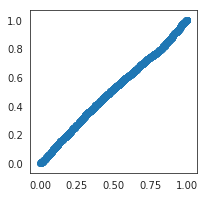

In [60]:
plt.figure(figsize=(3,3))
plt.scatter(ECDF(res_normal)(res_normal), norm.cdf(res_normal))

In [75]:
# Generate mu0 and sigma0 for the test set
mu_0 = model.predict(test_contest.loc[:, 'rep_incumbent':].values)
sigma2_0 = train_info.groupby('state')['residual_sq'].mean()
test_info['sigma2_0'] = test_info['state'].apply(lambda x: sigma2_0[x])
sigma2_0 = test_info['sigma2_0'][test_contest.index]
Sigma_0 = np.diag(sigma2_0.values)

s_d = test_info.loc[test_contest.index][['state', 'district']]

for i in tqdm(range(len(Sigma_0))):
    for j in range(len(Sigma_0)):
        if i != j:
            (st, dis) = s_d.iloc[i]
            (st2, dis2) = s_d.iloc[j]
            Sigma_0[i, j] = emp_cov.loc[(st, dis), (st2, dis2)] * Sigma_0[i,i] * Sigma_0[j,j]
            

# First update - Generic ballot

In [79]:
generic_ballot = (pd.read_csv('https://projects.fivethirtyeight.com/generic-ballot-data/generic_ballot.csv')
                  .sort_values('date', ascending=False))
generic_ballot = generic_ballot.iloc[0]
z_thresh = 1.644854
sigma2_G = ((generic_ballot['rep_hi']/100 - generic_ballot['rep_lo']/100) / 2 / z_thresh) ** 2

In [80]:
n = len(Sigma_0)
observed = generic_ballot['rep_estimate'] / (generic_ballot['rep_estimate'] + generic_ballot['dem_estimate'])
observed = np.array([observed])
mu1 = np.array([mu_0.mean()])
v1 = np.array([[sigma2_G + Sigma_0.sum() / (n ** 2)]])
v01 = np.diag(Sigma_0)[:, np.newaxis] / n

In [81]:
def normal_conditioning(mu0, mu1, v0, v1, v01, observed):
    new_mu = mu0 + v01 @ np.linalg.inv(v1) @ (observed - mu1)
    new_v = v0 - v01 @ np.linalg.inv(v1) @ v01.T
    return new_mu, new_v

In [82]:
mu_after_gen, sigma_after_gen = normal_conditioning(mu_0, mu1, Sigma_0, v1, v01, observed)

In [83]:
mu_after_gen.mean()

0.4843991527920027

# Second update - Polls

In [113]:
polls = feather.read_dataframe('polls.feather')
sigma2_poll = polls.groupby(['state', 'fivethirtyeight_district'])['rep_score'].std() ** 2
sigma2_poll = sigma2_poll.fillna(sigma2_poll.mean()).reset_index()
sigma2_poll.columns = ['state','fivethirtyeight_district','sigma2_poll']
polls = polls.merge(sigma2_poll)

In [125]:
polls[polls['state'] == 'New York']

,state,id,fivethirtyeight_district,created_at,sampleSize,rep_score,sigma2_poll
424,New York,83306,22,2018-03-12,500.0,0.468085,0.000902
425,New York,83345,22,2017-10-10,561.0,0.488636,0.000902
426,New York,83346,22,2017-11-10,599.0,0.465909,0.000902
427,New York,83353,22,2018-04-27,358.0,0.450000,0.000902
428,New York,86495,22,2018-08-29,499.0,0.488889,0.000902
429,New York,90309,22,2018-10-16,400.0,0.543478,0.000902
430,New York,90776,22,2018-10-24,501.0,0.494505,0.000902
431,New York,83482,19,2018-07-11,545.0,0.461538,0.000596
432,New York,86042,19,2018-08-14,400.0,0.526882,0.000596
433,New York,86508,19,2018-08-30,501.0,0.529412,0.000596


In [87]:
polls = (test_info.reset_index()
         .merge(polls, how='left').dropna()
         .sort_values('created_at').groupby('index')
         .apply(lambda x: x.iloc[-3:])
         .reset_index(drop=True).drop(['sigma2_0','id','created_at'], axis=1))

In [88]:
def update_poll(poll, mu, Sigma):
    m = pd.Series(mu, index=test_contest.index)
    ind = poll['index']
    mu1 = np.array([m[ind]])
    ej = pd.Series(np.zeros(len(test_contest)), 
                  index=test_contest.index)
    ej[ind] = 1
    ej = ej.values
    cov = (Sigma @ ej)[:, np.newaxis]
    v1 = np.array([[1/4/poll['sampleSize'] + poll['sigma2_poll'] + ej.dot(Sigma @ ej)]])
    observation = poll['rep_score']
    
    return normal_conditioning(mu, mu1, Sigma, v1, cov, observation)

In [89]:
mu, Sigma = mu_after_gen.copy(), sigma_after_gen.copy()

In [90]:
mu.mean()

0.4843991527920027

In [91]:
for _, poll in tqdm(polls.iterrows()):
    mu, Sigma = update_poll(poll, mu, Sigma)

In [92]:
mu.mean()

0.48206733532093543

In [107]:
sim = np.random.multivariate_normal(mu, Sigma, size=100000)

In [108]:
rep_uncon = df.query('raceyear==2018')['rep_uncontested'].sum()

In [109]:
(sim > .5).sum(axis=1).mean()

205.56778

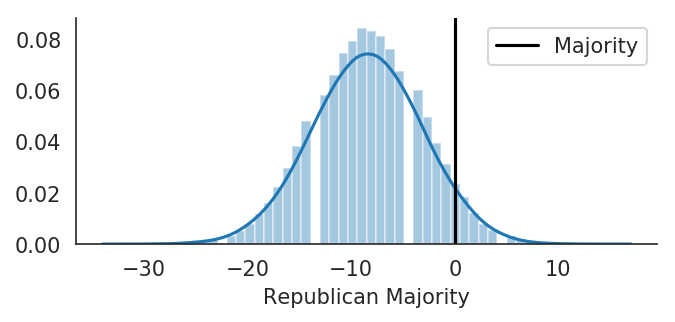

In [126]:
plt.figure(figsize=(5,2))
sns.distplot((sim > .5).sum(axis=1) + rep_uncon - 217, bins=50, kde_kws={'bw':1})
plt.axvline(0, color='k', label='Majority')
plt.xlabel('Republican Majority')
plt.legend()
# plt.xlim((195,235))
sns.despine()
plt.savefig('report/rep_seats.pdf')

In [127]:
1-((sim > .5).sum(axis=1) + 3 > 217.5).mean()

0.95415

In [ ]:
(sim > .5).sum(axis=1).std()

In [ ]:
test_info['mu'] = mu
test_info['sigma'] = np.diag(Sigma) ** .5

In [ ]:
test_info['edge'] = (test_info['mu'] - .5) / test_info['sigma']

In [ ]:
maps = gpd.read_file('data/kx-us-116th-congressional-districts-SHP (1)/us-116th-congressional-districts.shp')

In [ ]:
def wrapper(func, x):
    try:
        return func(x)
    except:
        return None

In [ ]:
maps['state_fips'] = maps['GEOID'].apply(lambda x : int(x[:2]))
maps['district'] = maps['GEOID'].apply(lambda x : wrapper(int, x[2:]))

In [ ]:
maps = maps[['state_fips', 'district', 'geometry']].copy()

In [ ]:
uncon = df.loc[test_uncontest.index, ['state_fips', 'district', 'rep_uncontested']].copy()

In [ ]:
uncon['mu'] = uncon['rep_uncontested'].astype(float)

In [ ]:
uncon['sigma'] = 0
uncon['edge'] = (uncon['mu'] - .5) * 40

In [ ]:
preds = pd.concat([test_info, uncon.drop('rep_uncontested', axis=1)], sort=False)

In [ ]:
final_map = maps.merge(preds, how='right', on=['state_fips', 'district'])

In [ ]:
f, ax = plt.subplots(1, figsize=(7, 5))
final_map.query('state not in ["Alaska", "Hawaii"]')[['geometry', 'mu']]\
.plot('mu', cmap='coolwarm', vmin=0.3, vmax=.7, 
      linewidth=0, figsize=(5,5), ax=ax)

ax.set_aspect(aspect=1.3)
ax.axis('off')

# plt.savefig('report/projected_map.eps')

# Produce a table of predictions

In [ ]:
preds['state'] = preds['state_fips'].apply(lambda x: us.states.lookup(str(x).zfill(2)).name)

In [ ]:
from scipy.stats import norm

In [ ]:
def compute_prob_republican(x):
    if x['sigma'] == 0:
        return x['mu']
    else:
        return 1 - norm.cdf((.5 - x['mu']) / x['sigma'])

In [ ]:
preds['republican_win_prob'] = preds.apply(compute_prob_republican, axis=1)

In [ ]:
preds = preds.merge(df.query('raceyear == 2018')[['state_fips', 'district', 'rep_lastname', 'dem_lastname']])

In [ ]:
preds['projected_winning_candidate'] = preds.apply(lambda x : x['rep_lastname']  + ' (R)'
                                                   if x['republican_win_prob'] > .5 
                                                   else x['dem_lastname'] + ' (D)', axis=1)


In [ ]:
preds['winner_prob'] = np.maximum(preds['republican_win_prob'], 1-preds['republican_win_prob'])

In [ ]:
preds['cong_district'] = preds['state'].astype(str) + '-' + preds['district'].astype(str).str.zfill(2)

In [ ]:
winners = preds.sort_values(['state', 'district'])[['cong_district', 'projected_winning_candidate', 'winner_prob']].copy()
winners.columns = ['District', 'Projected Winner', 'Probability']

In [ ]:
with open('report/projected_results.tex', 'w') as f:
    f.write(winners.to_latex(index=False, longtable=True))

In [ ]:
winners.to_csv('report/projections.csv', index=False)